## **HGSS x MiCM Transcriptomics Bootcamp - Intro to single-cell technologies**


## **Scanpy tutorial Introduction**
> - *This hands-on part is based on the [scanpy tutorial](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html)*
> - The goal of this tutorial is to try and reproduce the cell clustering from the ***CellRanger*** [summary report](web_summary.html)
> - Before you begin, you must first download the count matrix hdf5 file produced by ***CellRanger --count*** and save it in your current working folder


## Downloading the scanpy library
> - Copy and paste this command line into your notebook : `pip install scanpy`
>> - *Note: if you are using **Google colab** make sure to add `!` before you paste the line, such as you get: `!pip install scanpy`*

## Import the **scanpy** library 
>- import scanpy as sc

In [3]:
import scanpy as sc
import numpy as np

In [4]:
# verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')


/home/yasmin/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.23.5 scipy==1.9.3 pandas==1.5.2 scikit-learn==1.1.3 statsmodels==0.13.5 python-igraph==0.10.2 pynndescent==0.5.8


## **Task 1** : Read the h5 file into an andata object
>- Find the appropriate scanpy function on this [page](https://scanpy.readthedocs.io/en/stable/api.html) that will enable to read the count matrix file 

In [5]:
adata = sc.read_10x_h5('filtered_feature_bc_matrix.h5')
adata.var_names_make_unique()

reading filtered_feature_bc_matrix.h5
 (0:00:00)


/home/yasmin/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


## **Task 2** : Visualize the boxplot of the top 20 highest expressed genes
>- Refer to [here](https://scanpy.readthedocs.io/en/stable/api.html)


normalizing counts per cell
    finished (0:00:00)


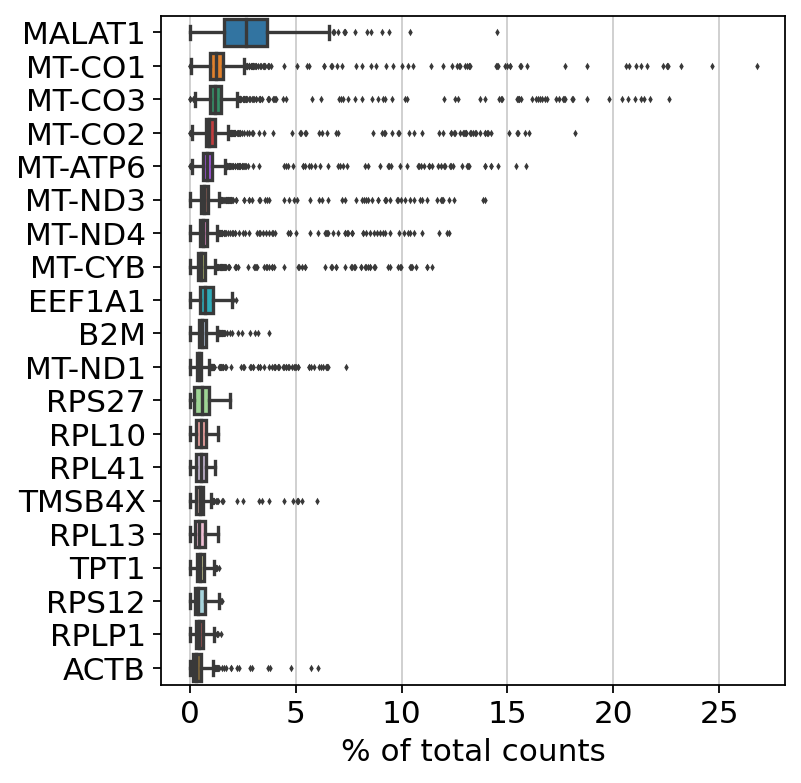

In [6]:
sc.pl.highest_expr_genes(adata, n_top=20)

## Filter out genes and cells


In [7]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 33 cells that have less than 200 genes expressed
filtered out 16395 genes that are detected in less than 3 cells


## **Task 3** : Plot a violin plot to vizualise
>- the number of genes expressed in the count matrix
>- the total counts per cell
>- the percentage of counts in mitochondrial genes



In [8]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')

In [9]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

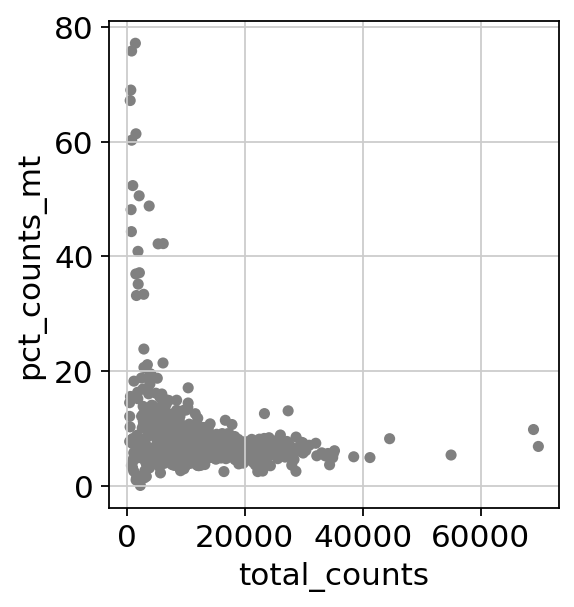

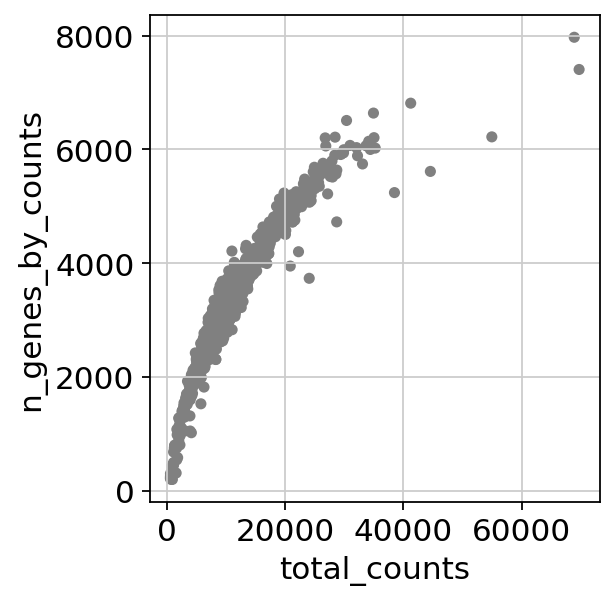

In [10]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

## **Task 4** : Find an appropriate threashold to filter out cells based on their percentage of mitochondrial genes

In [11]:
n = 7000
m = 20

adata = adata[adata.obs.n_genes_by_counts < n, :]
adata = adata[adata.obs.pct_counts_mt < m, :]

In [12]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

normalizing counts per cell
    finished (0:00:00)


/home/yasmin/.local/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


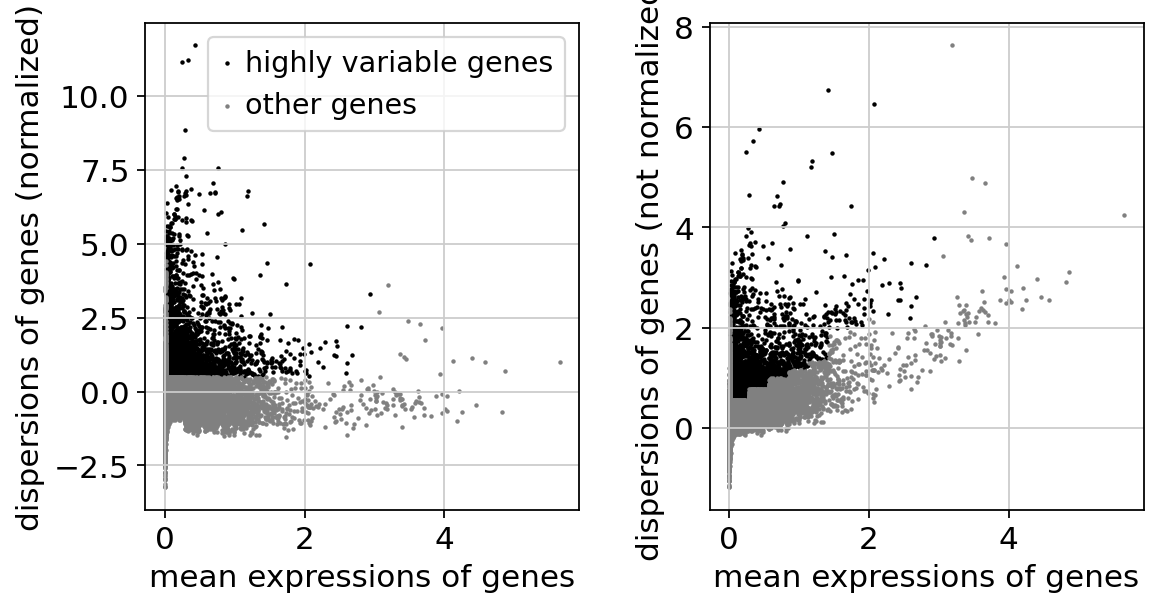

In [13]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)
adata = adata[:, adata.var.highly_variable]

## **Task 5** : Filter out non highly variable genes


In [14]:
adata = adata[:, adata.var.highly_variable]

## **Task 6** : Apply dimension reduction on the count matrix using t-sne

In [15]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:03)


computing tSNE
    using 'X_pca' with n_pcs = 50
    using sklearn.manifold.TSNE


/home/yasmin/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
running Leiden clustering
    finished: found 14 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


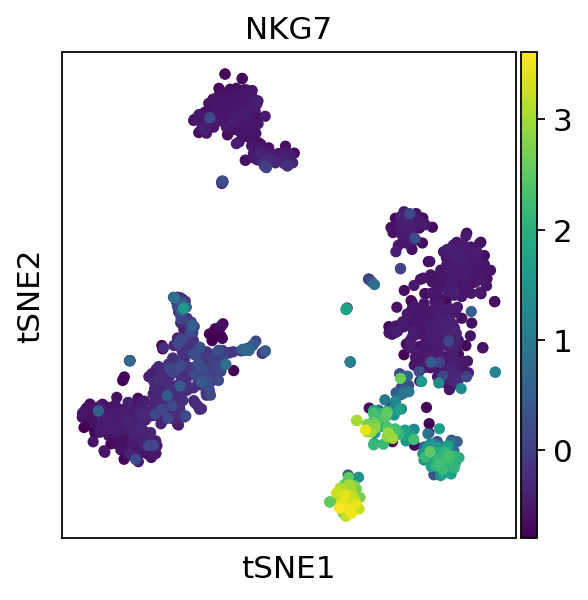

In [17]:
sc.tl.tsne(adata)
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.leiden(adata)
sc.pl.tsne(adata, color='NKG7')